In [1]:
from librarys.LiberiaUtilesRetoOmya import *
from collections import Counter
#Liberias de visualización
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import numpy as np


# Normalizacion
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

#Reduccion de dimensiones
from sklearn.decomposition import PCA


# Clustering
from sklearn.cluster import KMeans,DBSCAN

#Evaluacion del modelo de cluster
from sklearn.metrics import silhouette_score

import warnings
warnings.filterwarnings("ignore")

### Primero obtenemos los datos del excel y los guardamos como csv 

In [2]:
excelToCsv('data/raw_data.xlsx','extract_data')

_com.sap.ip.bi.xl.hiddensheet guardado correctamente.
data_hackaboss (MAIN DATA) guardado correctamente. Con el nombre Main
Explanation guardado correctamente.
COUNTRY guardado correctamente.
KEY ACCOUNT guardado correctamente.
CUSTOMER TYPE guardado correctamente.
CUST VALUE (1) guardado correctamente.
CUST VALUE (2) guardado correctamente.
BRAND guardado correctamente.
PLANT-SOURCING guardado correctamente.
TYPE guardado correctamente.
MATERIAL TYPE guardado correctamente.
PLANT TYPE guardado correctamente.


In [3]:
datos = obtener_tablas_dict('extract_data')

BRAND cargado correctamente.
COUNTRY cargado correctamente.
CUST VALUE (1) cargado correctamente.
CUST VALUE (2) cargado correctamente.
CUSTOMER TYPE cargado correctamente.
data_hackaboss (MAIN DATA) cargado correctamente.
Explanation cargado correctamente.
KEY ACCOUNT cargado correctamente.
Main cargado correctamente.
MATERIAL TYPE cargado correctamente.
PLANT TYPE cargado correctamente.
PLANT-SOURCING cargado correctamente.
TYPE cargado correctamente.
_com.sap.ip.bi.xl.hiddensheet está vacío y ha sido ignorado.


#### Una vez pre cargados los datos echaremos un vistazo para ver si vemos algo alarmante a sus metodos info y describe

In [4]:
informe_tablas(datos)

------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
Explorando BRAND:
-------------------------------------INFO-----------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   MATERIAL   10000 non-null  object
 1   BRAND      9999 non-null   object
 2   SUB_BRAND  9999 non-null   object
dtypes: object(3)
memory usage: 234.5+ KB
None
-------------------------------------DESCRIBE-----------------------------------------------------
         MATERIAL      BRAND     SUB_BRAND
count       10000       9999          9999
unique      10000       5711           150
top     MAT000001  Brand_388  Sub_Bra

### Lo siguiente al no tener una base de datos relacional aqui, vamos a unir las tablas por sus campos comunes mapeando la relaciones en un solo dataframe principal

In [5]:
df_main_data = datos['data_hackaboss (MAIN DATA)']
df_country = datos['COUNTRY']
df_customer_type = datos['CUSTOMER TYPE']
df_key_account = datos['KEY ACCOUNT']
df_brand = datos['BRAND']
df_material_type = datos['MATERIAL TYPE']
df_type = datos['TYPE']
df_plant_sourcing = datos['PLANT-SOURCING']

# Mapear y añadir "Country" desde df_country
customer_to_country = df_country.set_index('Ship to Customer')['Country'].to_dict()
df_main_data['Country'] = df_main_data['Ship to Customer'].map(customer_to_country)

# Mapear y añadir "Customer Type" desde df_customer_type
customer_to_customer_type = df_customer_type.set_index('Ship to Customer')['Customer_Type'].to_dict()
df_main_data['Customer Type'] = df_main_data['Ship to Customer'].map(customer_to_customer_type)

# Mapear y añadir "Key Account" y "Key Account Grouper" desde df_key_account
customer_to_key_account = df_key_account.set_index('Ship to Customer')[['Key_Account', 'Key_Account_Grouper']].to_dict(orient='index')
df_main_data = df_main_data.join(pd.DataFrame(df_main_data['Ship to Customer'].map(customer_to_key_account).tolist(), index=df_main_data.index))

# Mapear y añadir "Brand" y "Sub Brand" desde df_brand
material_to_brand = df_brand.set_index('MATERIAL')[['BRAND', 'SUB_BRAND']].to_dict(orient='index')
df_main_data = df_main_data.join(pd.DataFrame(df_main_data['MATERIAL'].map(material_to_brand).tolist(), index=df_main_data.index))

# Mapear y añadir "Material Type" desde df_material_type
material_to_material_type = df_material_type.set_index('MATERIAL')['Material_type'].to_dict()
df_main_data['Material Type'] = df_main_data['MATERIAL'].map(material_to_material_type)

# Mapear y añadir "Product Type" y "Product SubType" desde df_type
material_to_product_type = df_type.set_index('MATERIAL')[['Product_Type', 'Product_SubType']].to_dict(orient='index')
df_main_data = df_main_data.join(pd.DataFrame(df_main_data['MATERIAL'].map(material_to_product_type).tolist(), index=df_main_data.index))

# Mapear y añadir "Sourcing Plant" y "Sourcing Vendor" desde df_plant_sourcing
material_to_sourcing = df_plant_sourcing.set_index('MATERIAL')[['Sourcing_Plant', 'Sourcing_Vendor']].to_dict(orient='index')
df_main_data = df_main_data.join(pd.DataFrame(df_main_data['MATERIAL'].map(material_to_sourcing).tolist(), index=df_main_data.index))

In [6]:
#Vamos añadir tambien los Customer
#Mapeamos de la tabla customers 
df_auxiliar = df_customer_type.drop('Customer_Type',axis=1)
dic_consumidor = df_auxiliar.set_index('Ship to Customer').to_dict()['SoldTo']
df_main_data['Client'] = df_main_data['Ship to Customer'].map(dic_consumidor)

In [7]:
df_main_data.columns

Index(['ID', 'Ship to Customer', 'MATERIAL', 'Window', 'Other_Data', 'Month',
       'Sales_Qty_2024', 'Sales_Qty_2023', 'Sales_Qty_2022', 'Sales_Qty_2021',
       'Net_Sales_2024', 'Net_Sales_2023', 'Net_Sales_2022', 'Net_Sales_2021',
       'P2_2024', 'P2_2023', 'P2_2022', 'P2_2021', 'Country', 'Customer Type',
       'Key_Account', 'Key_Account_Grouper', 'BRAND', 'SUB_BRAND',
       'Material Type', 'Product_Type', 'Product_SubType', 'Sourcing_Plant',
       'Sourcing_Vendor', 'Client'],
      dtype='object')

### Verificamos los valores nulos

In [8]:
df_main_data.isna().sum()

ID                     0
Ship to Customer       0
MATERIAL               0
Window                 0
Other_Data             0
Month                  0
Sales_Qty_2024         0
Sales_Qty_2023         0
Sales_Qty_2022         0
Sales_Qty_2021         0
Net_Sales_2024         0
Net_Sales_2023         0
Net_Sales_2022         0
Net_Sales_2021         0
P2_2024                0
P2_2023                0
P2_2022                0
P2_2021                0
Country                0
Customer Type          0
Key_Account            0
Key_Account_Grouper    0
BRAND                  0
SUB_BRAND              0
Material Type          0
Product_Type           0
Product_SubType        0
Sourcing_Plant         0
Sourcing_Vendor        0
Client                 0
dtype: int64

In [9]:
df_main_data.columns

Index(['ID', 'Ship to Customer', 'MATERIAL', 'Window', 'Other_Data', 'Month',
       'Sales_Qty_2024', 'Sales_Qty_2023', 'Sales_Qty_2022', 'Sales_Qty_2021',
       'Net_Sales_2024', 'Net_Sales_2023', 'Net_Sales_2022', 'Net_Sales_2021',
       'P2_2024', 'P2_2023', 'P2_2022', 'P2_2021', 'Country', 'Customer Type',
       'Key_Account', 'Key_Account_Grouper', 'BRAND', 'SUB_BRAND',
       'Material Type', 'Product_Type', 'Product_SubType', 'Sourcing_Plant',
       'Sourcing_Vendor', 'Client'],
      dtype='object')

##### Se observa que hay nulos no declarados como tales si no por ejemplo en Windows Null es un string se tendrá en cuenta cuando se prepare el modelos si se usa esta columna

## OBJETIVOS

* Segmentación de Clientes:

    Identificar y definir segmentos de clientes basados en características específicas (por ejemplo, volumen de ventas, frecuencia de compra, etc.).

* Análisis Descriptivo y Exploratorio:

    Realizar un análisis descriptivo de las ventas y otros indicadores clave por segmento de cliente.

* Visualización de Datos:

    Crear visualizaciones que ayuden a los representantes de ventas a comprender mejor los segmentos de clientes.

* Análisis Predictivo:

    Si es necesario, implementar modelos de predicción para identificar tendencias y oportunidades dentro de cada segmento.

* Herramienta Estratégica:

    Desarrollar una herramienta (como un dashboard en Excel, Power BI, Tableau, etc.) que permita a los usuarios explorar los datos segmentados y tomar decisiones informadas.

Informacion sobre los datos de las columnas

| KPI                  | DESCRIPTION                                             |
|----------------------|---------------------------------------------------------|
| ID                   | Id of the row                                           |
| Country              | Country which customer belongs                          |
| Sold to Customer     | Customer                                                |
| Ship to Customer     | Delivery address                                        |
| Key Account          | Type of key account                                     |
| Key Account Grouper  | (No description provided)                               |
| Customer Type        | Market                                                  |
| Customer_Value1      | Manuel input for customer profiling                     |
| Customer_Value2      | Manuel input for customer profiling                     |
| MATERIAL             | Final Product that we sell                              |
| Material type        | Manufactured or Distributed                             |
| Sourcing Plant       | Information about Plant / or Supplier                   |
| Sourcing Vendor      | Information about Plant / or Supplier                   |
| Plant Types          | (No description provided)                               |
| Product Type         | Levels of Product attributes                            |
| Product SubType      | (No description provided)                               |
| BRAND                | Different Level of Product Hierarchy                    |
| SUB_BRAND            | (No description provided)                               |
| Window               | Product Flag                                            |
| Other Data           | Other Classification                                    |
| Month                | Month of the year                                       |
| SALES QUANTITTY      | Sales in Tons                                           |
| NET SALES            | Net Sales in EUROS                                      |
| P2                   | A type of Margin                                        |

Comenzaremos por los 3 puntos iniciales:

* Segmentación de Clientes:

    Identificar y definir segmentos de clientes basados en características específicas (por ejemplo, volumen de ventas, frecuencia de compra, etc.).
    
* Análisis Descriptivo y Exploratorio:

    Realizar un análisis descriptivo de las ventas y otros indicadores clave por segmento de cliente.

* Visualización de Datos:

    Crear visualizaciones que ayuden a los representantes de ventas a comprender mejor los segmentos de clientes.

In [10]:
df_clientes = pd.DataFrame()

In [11]:
#Añadimos las columnas necesarias para segmentar los clientes en un df nuevo
df_clientes['MATERIAL'] = df_main_data['MATERIAL']
df_clientes['Material Type'] = df_main_data['Material Type']
df_clientes['Ship to Customer'] = df_main_data['Ship to Customer']
df_clientes['Customer type'] = df_main_data['Customer Type']

In [12]:
#Mapeamos de la tabla customers para obtener los diferentes clientes
df_auxiliar = df_customer_type.drop('Customer_Type',axis=1)
dic_consumidor = df_auxiliar.set_index('Ship to Customer').to_dict()['SoldTo']
df_clientes['Client'] = df_clientes['Ship to Customer'].map(dic_consumidor)

In [13]:
df_clientes

MATERIAL    Material Type    Ship to Customer     Customer type  \
0      MAT001622  Material_Type_1  ShipToCustomer_804   Customer_Type_4   
1      MAT000093  Material_Type_1  ShipToCustomer_952   Customer_Type_3   
2      MAT002425  Material_Type_1  ShipToCustomer_551   Customer_Type_2   
3      MAT001731  Material_Type_2   ShipToCustomer_27   Customer_Type_3   
4      MAT002384  Material_Type_2  ShipToCustomer_560   Customer_Type_7   
...          ...              ...                 ...               ...   
99995  MAT000913  Material_Type_1  ShipToCustomer_910   Customer_Type_9   
99996  MAT002394  Material_Type_1  ShipToCustomer_482   Customer_Type_5   
99997  MAT002585  Material_Type_2  ShipToCustomer_180   Customer_Type_7   
99998  MAT001194  Material_Type_2   ShipToCustomer_65   Customer_Type_1   
99999  MAT002654  Material_Type_1  ShipToCustomer_784  Customer_Type_10   

              Client  
0      Customer_5922  
1      Customer_6726  
2      Customer_7395  
3      Customer_4533  
4       Customer_114  
...              ...  
99995   Customer_818  
99996  Customer_1314  
99997  Customer_4708  
99998  Customer_3295  
99999  Customer_2755  

[100000 rows x 5 columns]

In [14]:
df_clientes.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   MATERIAL          100000 non-null  object
 1   Material Type     100000 non-null  object
 2   Ship to Customer  100000 non-null  object
 3   Customer type     100000 non-null  object
 4   Client            100000 non-null  object
dtypes: object(5)
memory usage: 3.8+ MB


In [15]:

df_clientes['Client'].value_counts()

Client
Customer_2350    321
Customer_2507    294
Customer_4178    233
Customer_244     229
Customer_6975    227
                ... 
Customer_2024     74
Customer_3007     74
Customer_3529     74
Customer_2763     73
Customer_3029     71
Name: count, Length: 926, dtype: int64

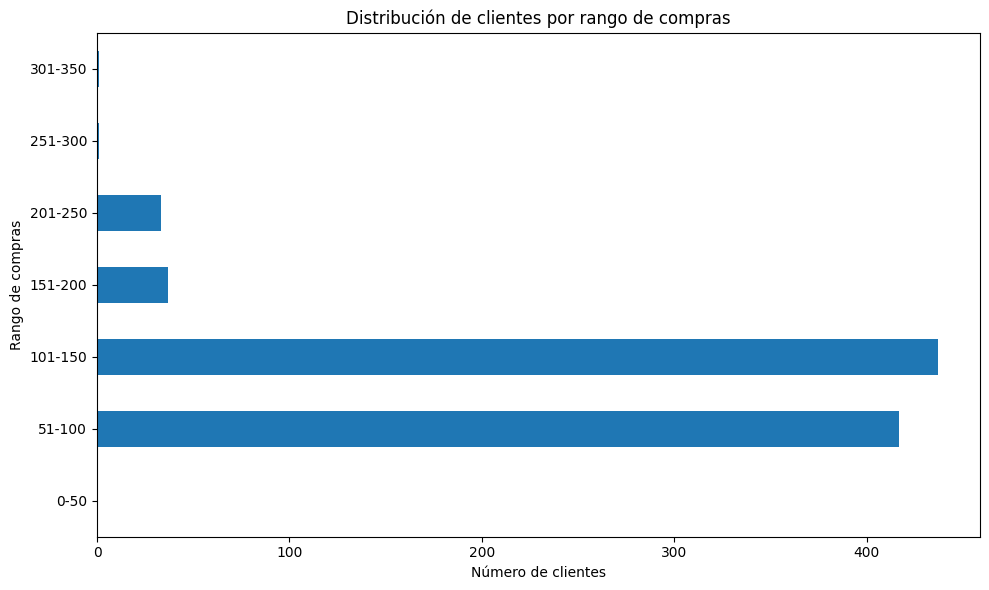

In [16]:
# Contar el número de compras por cliente
client_counts = df_clientes['Client'].value_counts()

# Agrupar clientes en diferentes rangos de compras
bins = [0, 50, 100, 150, 200, 250, 300, 350]
labels = ['0-50', '51-100', '101-150', '151-200', '201-250', '251-300', '301-350']

# Calcular el conteo de clientes en cada categoría
clients_by_range = pd.cut(client_counts, bins=bins, labels=labels, right=False)
clients_by_range_counts = clients_by_range.value_counts().sort_index()

# Graficar
plt.figure(figsize=(10, 6))
clients_by_range_counts.plot(kind='barh')
plt.ylabel('Rango de compras')
plt.xlabel('Número de clientes')
plt.title('Distribución de clientes por rango de compras')
plt.tight_layout()
plt.show()

In [17]:
# Suponiendo que client_counts y labels ya están definidos como en tu código original

# Crear DataFrame con los datos
df_plot = pd.DataFrame({'Rango de compras': labels, 'Número de clientes': clients_by_range_counts.values})

# Crear gráfico interactivo con Plotly
fig = px.bar(df_plot, 
             x='Número de clientes', 
             y='Rango de compras', 
             orientation='h', 
             text='Número de clientes',
             title='Distribución de clientes por rango de compras',
             labels={'Número de clientes': 'Número de clientes', 'Rango de compras': 'Rango de compras'})

# Personalización adicional del gráfico
fig.update_traces(textposition='inside', textfont_size=14)
fig.update_layout(xaxis_title='Número de clientes',
                  yaxis_title='Rango de compras',
                  height=600, width=800)

# Mostrar el gráfico interactivo
fig.show()

Al observar el primer gráfico quise saber que cantidad exacta de clientes estaba segmentando por eso utilize plotly , la mayor parte de los clientes estan en rangos de compra de 101-150 y 51-100

In [18]:
# Calcular la segmentación para cada cliente
segmentacion = pd.cut(client_counts, bins=bins, labels=labels, right=False)

# Añadir la nueva columna 'Segmentacion' al DataFrame df_clientes
df_clientes['Segmentacion'] = segmentacion



In [19]:
dic_aux = df_clientes['Client'].value_counts().to_dict()
df_clientes['Number of sales'] = df_clientes['Client'].map(dic_aux)

In [20]:
# No se por que antes me salian nulos al aplicar sin crear de nuevo bins and labels probé creandolas de nuevo y funciono
bins = [0, 50, 100, 150, 200, 250, 300, 350]
labels = ['0-50', '51-100', '101-150', '151-200', '201-250', '251-300', '301-350']
df_clientes['Segmentacion'] = pd.cut(df_clientes['Number of sales'], bins=bins, labels=labels, right=False)

In [21]:
df_clientes


MATERIAL    Material Type    Ship to Customer     Customer type  \
0      MAT001622  Material_Type_1  ShipToCustomer_804   Customer_Type_4   
1      MAT000093  Material_Type_1  ShipToCustomer_952   Customer_Type_3   
2      MAT002425  Material_Type_1  ShipToCustomer_551   Customer_Type_2   
3      MAT001731  Material_Type_2   ShipToCustomer_27   Customer_Type_3   
4      MAT002384  Material_Type_2  ShipToCustomer_560   Customer_Type_7   
...          ...              ...                 ...               ...   
99995  MAT000913  Material_Type_1  ShipToCustomer_910   Customer_Type_9   
99996  MAT002394  Material_Type_1  ShipToCustomer_482   Customer_Type_5   
99997  MAT002585  Material_Type_2  ShipToCustomer_180   Customer_Type_7   
99998  MAT001194  Material_Type_2   ShipToCustomer_65   Customer_Type_1   
99999  MAT002654  Material_Type_1  ShipToCustomer_784  Customer_Type_10   

              Client Segmentacion  Number of sales  
0      Customer_5922      201-250              209  
1      Customer_6726      101-150              108  
2      Customer_7395      101-150              105  
3      Customer_4533      101-150              112  
4       Customer_114       51-100               95  
...              ...          ...              ...  
99995   Customer_818      101-150              115  
99996  Customer_1314      101-150              104  
99997  Customer_4708      101-150              114  
99998  Customer_3295      101-150              105  
99999  Customer_2755      101-150              105  

[100000 rows x 7 columns]

In [22]:
df_clientes[df_clientes['Client'] == 'Customer_5922']

MATERIAL    Material Type    Ship to Customer    Customer type  \
0      MAT001622  Material_Type_1  ShipToCustomer_804  Customer_Type_4   
67     MAT001837  Material_Type_1  ShipToCustomer_804  Customer_Type_4   
633    MAT002764  Material_Type_2  ShipToCustomer_804  Customer_Type_4   
1444   MAT000748  Material_Type_2   ShipToCustomer_17  Customer_Type_6   
3098   MAT000114  Material_Type_1   ShipToCustomer_17  Customer_Type_6   
...          ...              ...                 ...              ...   
96493  MAT001622  Material_Type_1  ShipToCustomer_804  Customer_Type_4   
97005  MAT001622  Material_Type_1  ShipToCustomer_804  Customer_Type_4   
97298  MAT001622  Material_Type_1  ShipToCustomer_804  Customer_Type_4   
97696  MAT001622  Material_Type_1  ShipToCustomer_804  Customer_Type_4   
98534  MAT001837  Material_Type_1  ShipToCustomer_804  Customer_Type_4   

              Client Segmentacion  Number of sales  
0      Customer_5922      201-250              209  
67     Customer_5922      201-250              209  
633    Customer_5922      201-250              209  
1444   Customer_5922      201-250              209  
3098   Customer_5922      201-250              209  
...              ...          ...              ...  
96493  Customer_5922      201-250              209  
97005  Customer_5922      201-250              209  
97298  Customer_5922      201-250              209  
97696  Customer_5922      201-250              209  
98534  Customer_5922      201-250              209  

[209 rows x 7 columns]

Esta ultima comprobación se realiza para visualizar que hay informacion redundante , en este caso la dejaremos asi por que el df es manejable y ligero pero en datos con mas peso intentariamos utilizar alguna tecnica para subsanar que para el cliente 5922 que en el ejemplo tiene 209x2  filas con la misma informacion esto podria hacerse aparte en una tabla nueva y acceder a ella cuando fuese necesario. 

Dicho lo cual tambien se aprecia que tiene 2 tipos de consumo y 2 direcciones esto es correcto si vamos a la tabla correspondiente y verificamos estos datos linea de codigo que incluyo en este texto a continuacion:

df_customer_type[df_customer_type['SoldTo'] == 'Customer_5922']

Hasta aqui tenemos los clientes por volumen de compras agrupados por su segmento correspondiente en un rango de compras. Pero para las siguientes comprobaciones voy a aislar esta tabla clientes de la siguiente en la que solo habra una fila por cliente

In [23]:
df_unReg = pd.DataFrame()

In [24]:
dic_aux = df_clientes[['Client','Segmentacion']].set_index('Client').to_dict()['Segmentacion']


In [25]:
df_unReg['Client'] = df_clientes['Client'].unique()  
df_unReg['Segmentacion'] = df_unReg['Client'].map(dic_aux)
df_unReg['Number of sales'] = df_unReg['Client'].map(df_clientes[['Client','Number of sales']].set_index('Client').to_dict()['Number of sales'])

Hasta aqui tenemos la informacion de la otra tabla pero con registros unicos ahora añadiremos el volumen en toneladas de material y el volumen de ventas totales en euros, dichos registros estan en 4 años asi que crearemos 8 columnas para que luego al hacer el estudio quede todo mas claro y si creo oportuno tambien añadire 2 mas con las sumas de los 4 años por cliente en los dos ambitos ya mencionados

In [26]:
df_unReg

Client Segmentacion  Number of sales
0    Customer_5922      201-250              209
1    Customer_6726      101-150              108
2    Customer_7395      101-150              105
3    Customer_4533      101-150              112
4     Customer_114       51-100               95
..             ...          ...              ...
921  Customer_6856      101-150              115
922  Customer_6066      101-150              105
923  Customer_1550      101-150              103
924  Customer_6255       51-100               80
925  Customer_5486      101-150              108

[926 rows x 3 columns]

In [27]:
df_main_data[df_main_data['Client'] == 'Customer_5922']['Sales_Qty_2024'].sum()

65979718

In [28]:
def obtenerDicClientes() -> dict:
    dic_clientes = {}
    for cliente in df_unReg['Client'].to_list():
        dic_clientes[cliente] = 0
    return dic_clientes

### Los siguientes bucles para la obtencion del valor total por cada año de las ventas por toneladas y en euros podriamos ponerlos juntos pero para hacer el codigo mas legible vamos hacerlo en 2 bloques 

##### Bloque 1

In [29]:
#----------------------------Bucle para volumen de ventas en toneladas 2024---------------------------------------
dic_aux = obtenerDicClientes()
for cliente in df_unReg['Client'].to_list():
    dic_aux[cliente] = df_main_data[df_main_data['Client'] == cliente]['Sales_Qty_2024'].sum()
df_unReg['Sales_Qty_2024'] = df_unReg['Client'].map(dic_aux)
#-----------------------------------------------------------------------------------------------------------------

#----------------------------Bucle para volumen de ventas en toneladas 2023---------------------------------------
dic_aux = obtenerDicClientes()
for cliente in df_unReg['Client'].to_list():
    dic_aux[cliente] = df_main_data[df_main_data['Client'] == cliente]['Sales_Qty_2023'].sum()
df_unReg['Sales_Qty_2023'] = df_unReg['Client'].map(dic_aux)
#-----------------------------------------------------------------------------------------------------------------

#----------------------------Bucle para volumen de ventas en toneladas 2022---------------------------------------
dic_aux = obtenerDicClientes()
for cliente in df_unReg['Client'].to_list():
    dic_aux[cliente] = df_main_data[df_main_data['Client'] == cliente]['Sales_Qty_2022'].sum()
df_unReg['Sales_Qty_2022'] = df_unReg['Client'].map(dic_aux)
#-----------------------------------------------------------------------------------------------------------------

#----------------------------Bucle para volumen de ventas en toneladas 2021---------------------------------------
dic_aux = obtenerDicClientes()
for cliente in df_unReg['Client'].to_list():
    dic_aux[cliente] = df_main_data[df_main_data['Client'] == cliente]['Sales_Qty_2021'].sum()
df_unReg['Sales_Qty_2021'] = df_unReg['Client'].map(dic_aux)
#-----------------------------------------------------------------------------------------------------------------



##### Bloque 2

In [30]:
#----------------------------Bucle para volumen de ventas en euros 2024---------------------------------------
dic_aux = obtenerDicClientes()
for cliente in df_unReg['Client'].to_list():
    dic_aux[cliente] = df_main_data[df_main_data['Client'] == cliente]['Net_Sales_2024'].sum()
df_unReg['Net_Sales_2024'] = df_unReg['Client'].map(dic_aux)
#-----------------------------------------------------------------------------------------------------------------

#----------------------------Bucle para volumen de ventas en euros 2023---------------------------------------
dic_aux = obtenerDicClientes()
for cliente in df_unReg['Client'].to_list():
    dic_aux[cliente] = df_main_data[df_main_data['Client'] == cliente]['Net_Sales_2023'].sum()
df_unReg['Net_Sales_2023'] = df_unReg['Client'].map(dic_aux)
#-----------------------------------------------------------------------------------------------------------------

#----------------------------Bucle para volumen de ventas en euros 2022---------------------------------------
dic_aux = obtenerDicClientes()
for cliente in df_unReg['Client'].to_list():
    dic_aux[cliente] = df_main_data[df_main_data['Client'] == cliente]['Net_Sales_2022'].sum()
df_unReg['Net_Sales_2022'] = df_unReg['Client'].map(dic_aux)
#-----------------------------------------------------------------------------------------------------------------

#----------------------------Bucle para volumen de ventas en euros 2021---------------------------------------
dic_aux = obtenerDicClientes()
for cliente in df_unReg['Client'].to_list():
    dic_aux[cliente] = df_main_data[df_main_data['Client'] == cliente]['Net_Sales_2021'].sum()
df_unReg['Net_Sales_2021'] = df_unReg['Client'].map(dic_aux)
#-----------------------------------------------------------------------------------------------------------------

In [31]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [32]:
df_unReg.columns

Index(['Client', 'Segmentacion', 'Number of sales', 'Sales_Qty_2024',
       'Sales_Qty_2023', 'Sales_Qty_2022', 'Sales_Qty_2021', 'Net_Sales_2024',
       'Net_Sales_2023', 'Net_Sales_2022', 'Net_Sales_2021'],
      dtype='object')

In [33]:
df_unReg.Segmentacion.value_counts()

Segmentacion
101-150    437
51-100     417
151-200     37
201-250     33
251-300      1
301-350      1
Name: count, dtype: int64

In [34]:
df_unReg['Segmentacion'] = pd.Categorical(df_unReg['Segmentacion'], categories=[
    '51-100', '101-150', '151-200', '201-250', '251-300', '301-350'], ordered=True)

# Agrupar por segmento y sumar el número de ventas
sales_by_segment = df_unReg.groupby('Segmentacion')['Number of sales'].sum().sort_index()

# Crear el gráfico interactivo
fig = px.bar(sales_by_segment, x=sales_by_segment.index, y=sales_by_segment.values,
             labels={'x': 'Segmentación', 'y': 'Número de Ventas'},
             title='Número de Ventas por Segmento')

fig.show()

La distribución de clientes por rango de compras revela una tendencia interesante. A pesar de que los clientes que realizan entre 201-250 compras destacan individualmente por su alta frecuencia de compras, colectivamente, el volumen de ventas generado por los clientes que se encuentran en el rango de 101-150 es considerablemente mayor. Este fenómeno se explica por la gran cantidad de clientes en este rango intermedio. En otras palabras, aunque los clientes grandes (aquellos que realizan un mayor número de compras) son destacados, el volumen de ventas total de los clientes medianos y pequeños supera al de los grandes. Esto resalta la importancia del segmento de clientes medianos y pequeños en el volumen de ventas total.

In [35]:
# Agrupar por segmento y sumar las ventas en toneladas
tonnes_by_segment = df_unReg.groupby('Segmentacion')['Sales_Qty_2024'].sum().sort_index()

# Crear el gráfico interactivo
fig = px.bar(tonnes_by_segment, x=tonnes_by_segment.index, y=tonnes_by_segment.values,
             labels={'x': 'Segmentación', 'y': 'Ventas Totales en Toneladas (2024)'},
             title='Ventas Totales en Toneladas por Segmento')

fig.show()

Idem de la gráfica anterior que por lógica deberia ser asi al igual que la siguiente que es la suma de la segmentación en euros deberia de ser identica en el sentido de que los clientes pequeños y medianos superan finalmente en facturación a los clientes grandes

In [36]:
# Agrupar por segmento y sumar los ingresos
revenue_by_segment = df_unReg.groupby('Segmentacion')['Net_Sales_2024'].sum().sort_index()

# Crear el gráfico interactivo
fig = px.bar(revenue_by_segment, x=revenue_by_segment.index, y=revenue_by_segment.values,
             labels={'x': 'Segmentación', 'y': 'Ingresos Totales en Euros (2024)'},
             title='Ingresos Totales en Euros por Segmento')

fig.show()

Y evidentemente como se comento con anterioridad la lógica se sigue cumpliendo.



In [37]:
# Agrupar y sumar los ingresos por segmentación
segment_summary = df_unReg.groupby('Segmentacion')['Net_Sales_2024'].sum().reset_index()

# Ordenar los segmentos por las categorías definidas (de menor a mayor)
segment_summary = segment_summary.sort_values(by='Segmentacion')

# Crear el gráfico de Pareto con segmentación en el eje X
fig = go.Figure()

# Añadir las barras
fig.add_trace(go.Bar(
    x=segment_summary['Segmentacion'],
    y=segment_summary['Net_Sales_2024'],
    name='Ingresos en Euros',
    marker_color='blue'
))

# Añadir una línea acumulativa
fig.add_trace(go.Scatter(
    x=segment_summary['Segmentacion'],
    y=segment_summary['Net_Sales_2024'].cumsum() / segment_summary['Net_Sales_2024'].sum(),
    mode='lines+markers',
    name='Porcentaje Acumulativo',
    yaxis='y2'
))

# Configurar ejes
fig.update_layout(
    title='Análisis de Pareto por Segmentación',
    xaxis=dict(title='Segmentación'),
    yaxis=dict(title='Ingresos en Euros'),
    yaxis2=dict(title='Porcentaje Acumulativo', overlaying='y', side='right', tickformat='.1%')
)

# Añadir una línea horizontal al 80%
fig.add_shape(type='line', x0=-0.5, y0=0.8, x1=len(segment_summary)-0.5, y1=0.8,
              line=dict(color='red', dash='dash'))

# Ajustar el tamaño y mostrar el gráfico
fig.update_layout(height=600, width=1000)
fig.show()

Observando la linea roja del gráfico de pareto vemos que el 85% de los ingresos estan entre los clientes segmentados entre el 101-150 y 51-100 lo que vuelve a verificar las conclusiones de las gráficas anteriores.

In [38]:
df_unReg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 926 entries, 0 to 925
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   Client           926 non-null    object  
 1   Segmentacion     926 non-null    category
 2   Number of sales  926 non-null    int64   
 3   Sales_Qty_2024   926 non-null    int64   
 4   Sales_Qty_2023   926 non-null    int64   
 5   Sales_Qty_2022   926 non-null    int64   
 6   Sales_Qty_2021   926 non-null    int64   
 7   Net_Sales_2024   926 non-null    float64 
 8   Net_Sales_2023   926 non-null    float64 
 9   Net_Sales_2022   926 non-null    float64 
 10  Net_Sales_2021   926 non-null    float64 
dtypes: category(1), float64(4), int64(5), object(1)
memory usage: 73.6+ KB


In [39]:
df_cluster = df_unReg.copy()
label_encoder = LabelEncoder()
df_cluster['Client_encoded'] = label_encoder.fit_transform(df_cluster['Client'])
label_encoder = LabelEncoder()
df_cluster['Segmentacion_encoded'] = label_encoder.fit_transform(df_cluster['Segmentacion'])

In [40]:
df_cluster.head(1)

Client Segmentacion  Number of sales  Sales_Qty_2024  \
0  Customer_5922      201-250              209        65979718   

   Sales_Qty_2023  Sales_Qty_2022  Sales_Qty_2021  Net_Sales_2024  \
0        59870239        64088843        70939793   3795941500.04   

   Net_Sales_2023  Net_Sales_2022  Net_Sales_2021  Client_encoded  \
0   3435154012.45   3786235454.36   4322058521.18             650   

   Segmentacion_encoded  
0                     2

Una vez transformadas las categoricas en numericas vamos a normalizar en este caso usare el MinMaxScaler


In [41]:
# Selección de características relevantes y normalización
features = df_cluster[['Segmentacion_encoded', 'Number of sales', 'Sales_Qty_2024',
                       'Sales_Qty_2023', 'Sales_Qty_2022', 'Sales_Qty_2021', 
                       'Net_Sales_2024', 'Net_Sales_2023', 'Net_Sales_2022','Net_Sales_2021', 'Client_encoded']]

scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)

Silhouette Score: 0.5431228324726894


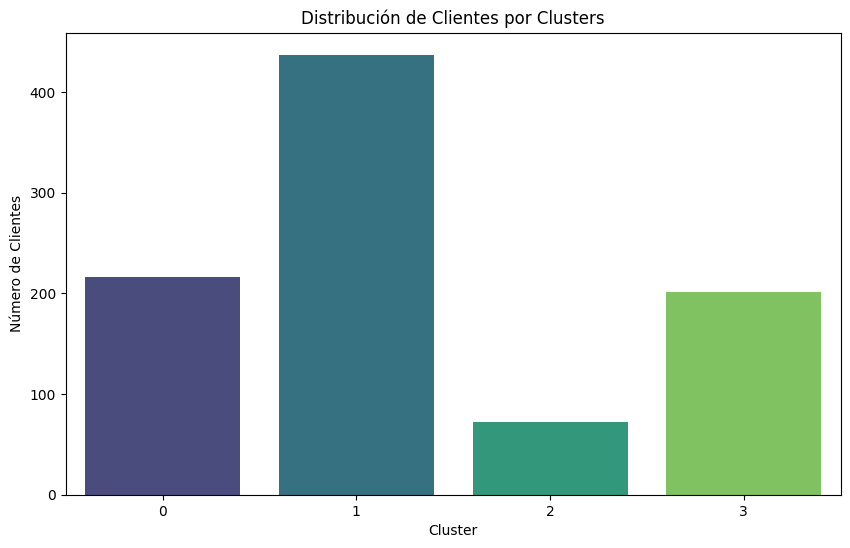

In [42]:
# Aplicación de K-means
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(features_scaled)

# Agregar los clusters al DataFrame original
df_cluster['Cluster'] = clusters

# Evaluación del clustering
silhouette_avg = silhouette_score(features_scaled, clusters)
print(f"Silhouette Score: {silhouette_avg}")

# Visualización de la distribución de clusters


plt.figure(figsize=(10, 6))
sns.countplot(x='Cluster', data=df_cluster, palette='viridis')
plt.title('Distribución de Clientes por Clusters')
plt.xlabel('Cluster')
plt.ylabel('Número de Clientes')
plt.show()

In [43]:
for i in range(2,10 + 1):
    # Inicializar K-means con el número actual de clusters
    kmeans = KMeans(n_clusters=i, random_state=42)
    
    # Ajustar K-means al conjunto de datos
    clusters = kmeans.fit_predict(features_scaled)
    
    # Calcular el Silhouette Score
    silhouette_avg = silhouette_score(features_scaled, clusters)
    
    # Imprimir el Silhouette Score y el número actual de clusters (i)
    print(f"Silhouette Score para {i} clusters: {silhouette_avg}")

Silhouette Score para 2 clusters: 0.5572154581877895
Silhouette Score para 3 clusters: 0.6184717779109616
Silhouette Score para 4 clusters: 0.5431228324726894
Silhouette Score para 5 clusters: 0.47051208592282506
Silhouette Score para 6 clusters: 0.4068243946960353
Silhouette Score para 7 clusters: 0.3497733391341968
Silhouette Score para 8 clusters: 0.33354485523503447
Silhouette Score para 9 clusters: 0.3004619528038979
Silhouette Score para 10 clusters: 0.30010769648988234


Observamos que para 3 clusters la silluete score es bastante alta

In [44]:
# Inicializar K-means con el número de clusters
kmeans = KMeans(n_clusters=3, random_state=42)

# Ajustar K-means al conjunto de datos escalados
clusters = kmeans.fit_predict(features_scaled)
# Agregar los clusters al DataFrame original
df_cluster['Cluster'] = clusters

# Crear una figura de tamaño 10x6 pulgadas
plt.figure(figsize=(10, 6))

# Graficar los datos originales con colores según los clusters asignados por K-means
sns.scatterplot(x=features_scaled[:, 2], y=features_scaled[:, 3], hue=clusters, palette="Accent")

# Graficar los centroides de los clusters
plt.scatter(kmeans.cluster_centers_[:, 2], kmeans.cluster_centers_[:, 3], color="red", marker="*", s=300, label='Centroides')

# Configurar título y leyendas
plt.title(f"Clustering con KMeans (3)")
plt.legend()

# Mostrar el gráfico
plt.show()

Hay un cluster claramente definido y 2 que al estar cerca tienden a la superposición aun asi tenemos una Silhouette Score para 3 clusters: 0.6222744208887063 

In [45]:
# Visualización interactiva de la distribución de clusters
fig = px.histogram(df_cluster, x='Cluster', title='Distribución de Clientes por Clusters')
fig.show()

 3 cluster que simbolizan 3 tipos de clientes diferentes ahora habria que ver si la clasificacion del modelo es correcta

In [46]:
df_unReg4Cluster = df_unReg.copy()

In [47]:
# Definir los nuevos rangos
bins = [0, 100, 200, 300, float('inf')]
labels = ['0-100', '101-200', '201-300', '301+']

# Reclasificar la columna 'Number of sales' en los nuevos rangos
df_unReg4Cluster['Segmentacion'] = pd.cut(df_unReg4Cluster['Number of sales'], bins=bins, labels=labels, right=False)



In [48]:
df_unReg4Cluster.head(1)

Client Segmentacion  Number of sales  Sales_Qty_2024  \
0  Customer_5922      201-300              209        65979718   

   Sales_Qty_2023  Sales_Qty_2022  Sales_Qty_2021  Net_Sales_2024  \
0        59870239        64088843        70939793   3795941500.04   

   Net_Sales_2023  Net_Sales_2022  Net_Sales_2021  
0   3435154012.45   3786235454.36   4322058521.18

In [49]:
# Agrupar por segmento y sumar las ventas en toneladas
tonnes_by_segment = df_unReg4Cluster.groupby('Segmentacion')['Sales_Qty_2024'].sum().sort_index()

# Crear el gráfico interactivo
fig = px.bar(tonnes_by_segment, x=tonnes_by_segment.index, y=tonnes_by_segment.values,
             labels={'x': 'Segmentación', 'y': 'Ventas Totales en Toneladas (2024)'},
             title='Ventas Totales en Toneladas por Segmento')

fig.show()

In [115]:
# Agrupar por segmento y sumar los ingresos
revenue_by_segment = df_unReg4Cluster.groupby('Segmentacion')['Net_Sales_2024'].sum().sort_index()

# Crear el gráfico interactivo
fig = px.bar(revenue_by_segment, x=revenue_by_segment.index, y=revenue_by_segment.values,
             labels={'x': 'Segmentación', 'y': 'Ingresos Totales en Euros (2024)'},
             title='Ingresos Totales en Euros por Segmento')

fig.show()

In [51]:
# Convertir 'Segmentacion' a categoría ordenada
df_unReg4Cluster['Segmentacion'] = pd.Categorical(df_unReg4Cluster['Segmentacion'], categories=['0-100', '101-200', '201-300', '301+'], ordered=True)

# Agrupar y sumar los ingresos por segmentación
segment_summary = df_unReg4Cluster.groupby('Segmentacion')['Net_Sales_2024'].sum().reset_index()

# Ordenar los segmentos por ingresos totales en 2024 y por el orden de las categorías
segment_summary = segment_summary.sort_values(by='Segmentacion')

# Crear el gráfico de Pareto con segmentación en el eje X
fig = px.bar(segment_summary, x='Segmentacion', y='Net_Sales_2024',
             labels={'Net_Sales_2024': 'Ingresos en Euros', 'Segmentacion': 'Segmentación'},
             title='Análisis de Pareto por Segmentación')

# Añadir una línea acumulativa
fig.add_scatter(x=segment_summary['Segmentacion'], y=segment_summary['Net_Sales_2024'].cumsum() / segment_summary['Net_Sales_2024'].sum(),
                mode='lines+markers', name='Porcentaje Acumulativo',
                yaxis='y2')

# Configurar ejes
fig.update_layout(yaxis2=dict(title='Porcentaje Acumulativo', overlaying='y', side='right', tickformat='.1%'))

# Añadir una línea horizontal al 80%
fig.add_shape(type='line', x0=0, y0=0.8, x1=len(segment_summary), y1=0.8,
              line=dict(color='red', dash='dash'))

# Ajustar el tamaño y mostrar el gráfico
fig.update_layout(height=600, width=1000)
fig.show()

Al igual en la prueba anterior la mayor parte de los ingresos esta en los 2 grupos pequeños en este caso el 92% de los ingresos se deben a estos dos grupos 101-200 y 0-100 llevando la misma linea que la anterior segmentacion en 6 pero mas concentrada

In [52]:
df_cluster2 = df_unReg4Cluster.copy()
label_encoder = LabelEncoder()
df_cluster2['Client_encoded'] = label_encoder.fit_transform(df_cluster2['Client'])
label_encoder = LabelEncoder()
df_cluster2['Segmentacion_encoded'] = label_encoder.fit_transform(df_cluster2['Segmentacion'])

In [53]:
# Selección de características relevantes y normalización
features2 = df_cluster2[['Segmentacion_encoded', 'Number of sales', 'Sales_Qty_2024',
                       'Sales_Qty_2023', 'Sales_Qty_2022', 'Sales_Qty_2021', 
                       'Net_Sales_2024', 'Net_Sales_2023', 'Net_Sales_2022','Net_Sales_2021', 'Client_encoded']]

scaler = MinMaxScaler()
features_scaled2 = scaler.fit_transform(features2)

In [54]:
# Aplicación de K-means
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(features_scaled2)

# Agregar los clusters al DataFrame original
df_cluster2['Cluster'] = clusters

# Evaluación del clustering
silhouette_avg = silhouette_score(features_scaled, clusters)
print(f"Silhouette Score: {silhouette_avg}")

# Visualización de la distribución de clusters


plt.figure(figsize=(10, 6))
sns.countplot(x='Cluster', data=df_cluster2, palette='viridis')
plt.title('Distribución de Clientes por Clusters')
plt.xlabel('Cluster')
plt.ylabel('Número de Clientes')
plt.show()

Silhouette Score: 0.3138572108039679


Al tener menor silluete score volvemos al modelos de 3 clusters

In [71]:
kmeans = KMeans(n_clusters=3, random_state=42)
# Ajustar K-means al conjunto de datos escalados
clusters = kmeans.fit_predict(features_scaled)
# Agregar los clusters al DataFrame original
df_cluster['Cluster'] = clusters

# Crear una figura de tamaño 10x6 pulgadas
plt.figure(figsize=(10, 6))

# Graficar los datos originales con colores según los clusters asignados por K-means
sns.scatterplot(x=features_scaled[:, 2], y=features_scaled[:, 3], hue=clusters, palette="Accent")

# Graficar los centroides de los clusters
plt.scatter(kmeans.cluster_centers_[:, 2], kmeans.cluster_centers_[:, 3], color="red", marker="*", s=300, label='Centroides')

# Configurar título y leyendas
plt.title(f"Clustering con KMeans (4)")
plt.legend()

# Mostrar el gráfico
plt.show()

En este caso de prueba hay aún mas superpocisión dado que el caso anterior es mejor y con mayor silhouette score usariamos la prueba anterior

In [56]:
#Este df tiene el cluster de k=3 y de silohouette 0.62
df_cluster.head(1)

Client Segmentacion  Number of sales  Sales_Qty_2024  \
0  Customer_5922      201-250              209        65979718   

   Sales_Qty_2023  Sales_Qty_2022  Sales_Qty_2021  Net_Sales_2024  \
0        59870239        64088843        70939793   3795941500.04   

   Net_Sales_2023  Net_Sales_2022  Net_Sales_2021  Client_encoded  \
0   3435154012.45   3786235454.36   4322058521.18             650   

   Segmentacion_encoded  Cluster  
0                     2        2

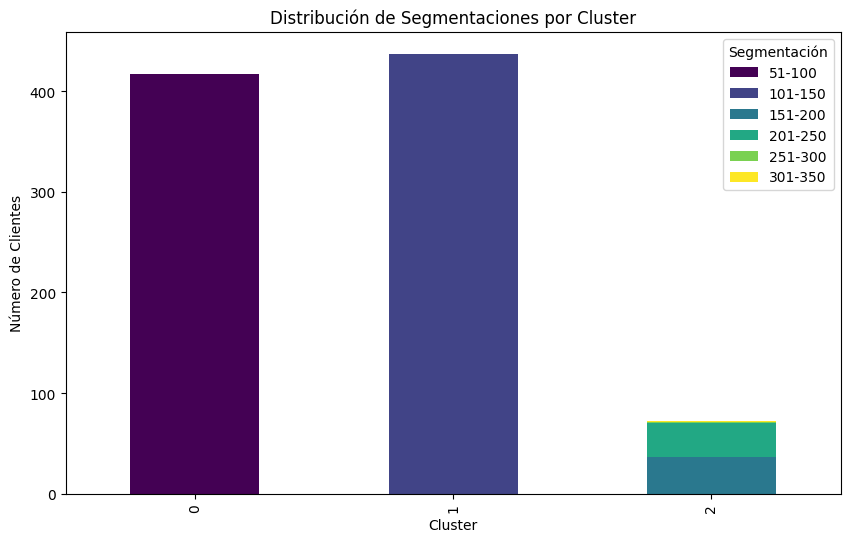

In [72]:
df_cluster['Segmentacion'] = pd.Categorical(df_cluster['Segmentacion'], categories=[
    '51-100', '101-150', '151-200', '201-250', '251-300', '301-350'], ordered=True)

# Agrupar por cluster y segmentación y contar el número de ocurrencias
segmentacion_por_cluster = df_cluster.groupby(['Cluster', 'Segmentacion']).size().unstack().fillna(0)

# Crear un gráfico de barras apiladas para visualizar la distribución de segmentaciones en cada cluster
segmentacion_por_cluster.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='viridis')

plt.title('Distribución de Segmentaciones por Cluster')
plt.xlabel('Cluster')
plt.ylabel('Número de Clientes')
plt.legend(title='Segmentación')
plt.show()

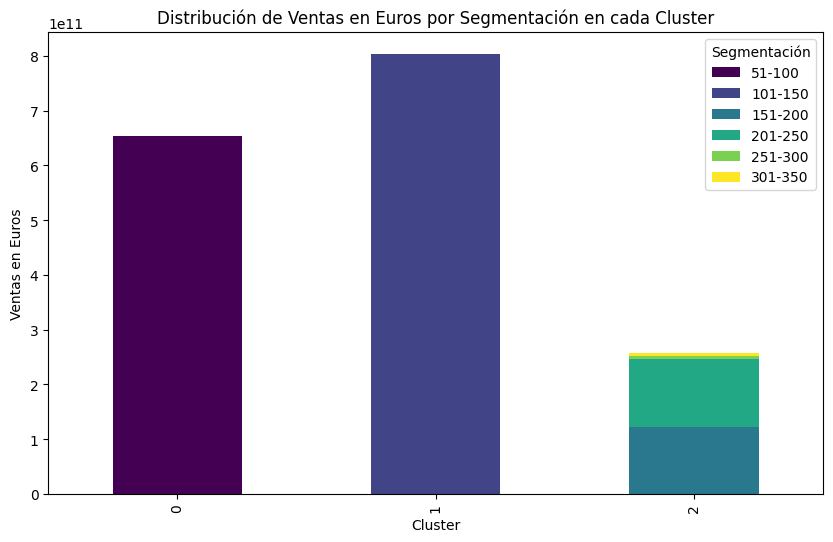

In [73]:
# Agrupar por cluster y segmentación y sumar los ingresos
ventas_por_cluster_segmentacion = df_cluster.groupby(['Cluster', 'Segmentacion'])['Net_Sales_2024'].sum().unstack().fillna(0)

# Crear un gráfico de barras apiladas para visualizar la distribución de ventas en euros por segmentación en cada cluster
ventas_por_cluster_segmentacion.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='viridis')

plt.title('Distribución de Ventas en Euros por Segmentación en cada Cluster')
plt.xlabel('Cluster')
plt.ylabel('Ventas en Euros')
plt.legend(title='Segmentación')
plt.show()

In [129]:
# Agrupar por cluster y segmentación y sumar los ingresos
ventas_por_cluster_segmentacion = df_cluster.groupby(['Cluster', 'Segmentacion'])['Net_Sales_2024'].sum().unstack().fillna(0)

# Crear el gráfico de barras apiladas interactivo
fig = go.Figure()

# Añadir una barra para cada segmentación
for segmentacion in ventas_por_cluster_segmentacion.columns:
    fig.add_trace(go.Bar(
        x=ventas_por_cluster_segmentacion.index,
        y=ventas_por_cluster_segmentacion[segmentacion],
        name=segmentacion
    ))

# Configurar el diseño del gráfico
fig.update_layout(
    title='Distribución de Ventas en Euros por Segmentación en cada Cluster',
    xaxis=dict(title='Cluster'),
    yaxis=dict(title='Ventas en Euros'),
    barmode='stack',
    legend_title='Segmentación',
    template='plotly'
)

# Mostrar el gráfico
fig.show()

Se observa que el modelo claramente es capaz de definir el cliente pequeño y mediano y agrupa los grandes por lo que considero que es un modelo eficaz a la hora de identificar a los clientes.

In [74]:
# Agrupar por cluster y sumar los ingresos para cada año
ventas_por_cluster_anio = df_cluster.groupby('Cluster')[['Net_Sales_2024', 'Net_Sales_2023', 'Net_Sales_2022', 'Net_Sales_2021']].sum()

# Resetear el índice para facilitar el uso en seaborn
ventas_por_cluster_anio = ventas_por_cluster_anio.reset_index()

# Crear el DataFrame en formato largo para seaborn
ventas_largo = ventas_por_cluster_anio.melt(id_vars='Cluster', value_vars=['Net_Sales_2024', 'Net_Sales_2023', 'Net_Sales_2022', 'Net_Sales_2021'],
                                            var_name='Año', value_name='Ventas')

# Crear el gráfico de barras agrupadas
plt.figure(figsize=(12, 8))
sns.barplot(x='Cluster', y='Ventas', hue='Año', data=ventas_largo, palette='viridis')

plt.title('Ventas por Cluster y Año')
plt.xlabel('Cluster')
plt.ylabel('Ventas en Euros')
plt.legend(title='Año')
plt.show()

Este gráfico es para afirmar que la tendencia de ingreso se mantiene en el tiempo dando lugar a que los clientes pequeños y medianos generan mas ingreso sutancialmente que lo grandes.

In [75]:
df_main_data.head(1)

ID    Ship to Customer   MATERIAL Window Other_Data  Month  Sales_Qty_2024  \
0   1  ShipToCustomer_804  MAT001622   Null     Data39     10               0   

   Sales_Qty_2023  Sales_Qty_2022  Sales_Qty_2021  ...    Material Type  \
0               0          456545          742378  ...  Material_Type_1   

       Product_Type        Product_SubType  Sourcing_Plant  Sourcing_Vendor  \
0  Product_Type_321  Product_SubType_321-3       Plant_421       Vendor_993   

          Client  Cluster  Key_Account_Simplified  \
0  Customer_5922        2                   Otros   

  Key_Account_Grouper_Simplified Product_Type_Simplified  
0                          Otros                   Otros  

[1 rows x 34 columns]

In [76]:
# Crear el diccionario de mapeo {Client: Cluster}
client_to_cluster = df_cluster.set_index('Client')['Cluster'].to_dict()

# Añadir la columna 'Cluster' a df_main_data mapeando los valores de 'Client' usando el diccionario
df_main_data['Cluster'] = df_main_data['Client'].map(client_to_cluster)

Una vez definimos los clusters haremos varias demostraciones de en que sectores se podria utilizar

In [77]:
# Agrupar clientes por tipo y cluster
df_client_type_cluster = df_main_data[['Client', 'Customer Type', 'Cluster']]
client_type_cluster_counts = df_client_type_cluster.groupby(['Cluster', 'Customer Type']).size().reset_index(name='Count')

plt.figure(figsize=(10, 6))
sns.barplot(x='Cluster', y='Count', hue='Customer Type', data=client_type_cluster_counts, palette='viridis')
plt.title('Distribución por Tipo de Cliente dentro de cada Cluster')
plt.xlabel('Cluster')
plt.ylabel('Número de Clientes')
plt.show()

Grafica para analizar que tipos  de clientes tenemos dentro de cada cluster

In [78]:
# Agrupar clientes por país y cluster
df_country_cluster = df_main_data[['Client', 'Country', 'Cluster']]
country_cluster_counts = df_country_cluster.groupby(['Cluster', 'Country']).size().reset_index(name='Count')

plt.figure(figsize=(10, 6))
sns.barplot(x='Cluster', y='Count', hue='Country', data=country_cluster_counts, palette='viridis')
plt.title('Distribución Geográfica de los Clientes por Clusters')
plt.xlabel('Cluster')
plt.ylabel('Número de Clientes')
plt.show()

Grafica para observación de la distribución del numero de clientes por cluster que pertenecen a cada país

In [79]:
# Agrupar clientes por mes y cluster
df_month_cluster = df_main_data[['Client', 'Month', 'Cluster']]
month_cluster_counts = df_month_cluster.groupby(['Cluster', 'Month']).size().reset_index(name='Count')

plt.figure(figsize=(10, 6))
sns.barplot(x='Cluster', y='Count', hue='Month', data=month_cluster_counts, palette='viridis')
plt.title('Distribución de Ventas por Mes dentro de cada Cluster')
plt.xlabel('Cluster')
plt.ylabel('Número de Ventas')
plt.show()

In [80]:
# Obtener las 10 categorías más frecuentes en 'Key_Account'
top_key_accounts = df_main_data['Key_Account'].value_counts().nlargest(10).index

# Crear una columna 'Key_Account_Simplified' donde las categorías menos frecuentes se agrupan en 'Otros'
df_main_data['Key_Account_Simplified'] = df_main_data['Key_Account'].apply(lambda x: x if x in top_key_accounts else 'Otros')

# Agrupar por cluster y la nueva columna 'Key_Account_Simplified'
df_key_account_cluster = df_main_data[['Client', 'Key_Account_Simplified', 'Cluster']]
key_account_cluster_counts = df_key_account_cluster.groupby(['Cluster', 'Key_Account_Simplified']).size().reset_index(name='Count')

plt.figure(figsize=(14, 8))
sns.barplot(x='Cluster', y='Count', hue='Key_Account_Simplified', data=key_account_cluster_counts, palette='viridis')
plt.title('Distribución por Tipo de Cuenta Clave (Simplificado) dentro de cada Cluster')
plt.xlabel('Cluster')
plt.ylabel('Número de Clientes')
plt.legend(title='Tipo de Cuenta Clave', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [81]:
# Filtrar las categorías 'Otros'
df_key_account_cluster_filtered = df_key_account_cluster[df_key_account_cluster['Key_Account_Simplified'] != 'Otros']

# Agrupar por cluster y la columna 'Key_Account_Simplified' sin 'Otros'
key_account_cluster_counts_filtered = df_key_account_cluster_filtered.groupby(['Cluster', 'Key_Account_Simplified']).size().reset_index(name='Count')

plt.figure(figsize=(14, 8))
sns.barplot(x='Cluster', y='Count', hue='Key_Account_Simplified', data=key_account_cluster_counts_filtered, palette='viridis')
plt.title('Distribución por Tipo de Cuenta Clave (Sin "Otros") dentro de cada Cluster')
plt.xlabel('Cluster')
plt.ylabel('Número de Clientes')
plt.legend(title='Tipo de Cuenta Clave', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [82]:
# Obtener las 10 categorías más frecuentes en 'Key_Account_Grouper'
top_key_account_groupers = df_main_data['Key_Account_Grouper'].value_counts().nlargest(10).index

# Crear una columna 'Key_Account_Grouper_Simplified' donde las categorías menos frecuentes se agrupan en 'Otros'
df_main_data['Key_Account_Grouper_Simplified'] = df_main_data['Key_Account_Grouper'].apply(lambda x: x if x in top_key_account_groupers else 'Otros')

# Agrupar por cluster y la nueva columna 'Key_Account_Grouper_Simplified'
df_key_account_grouper_cluster = df_main_data[['Client', 'Key_Account_Grouper_Simplified', 'Cluster']]
key_account_grouper_cluster_counts = df_key_account_grouper_cluster.groupby(['Cluster', 'Key_Account_Grouper_Simplified']).size().reset_index(name='Count')

plt.figure(figsize=(14, 8))
sns.barplot(x='Cluster', y='Count', hue='Key_Account_Grouper_Simplified', data=key_account_grouper_cluster_counts, palette='viridis')
plt.title('Distribución por Agrupador de Cuentas Clave (Simplificado) dentro de cada Cluster')
plt.xlabel('Cluster')
plt.ylabel('Número de Clientes')
plt.legend(title='Agrupador de Cuentas Clave', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

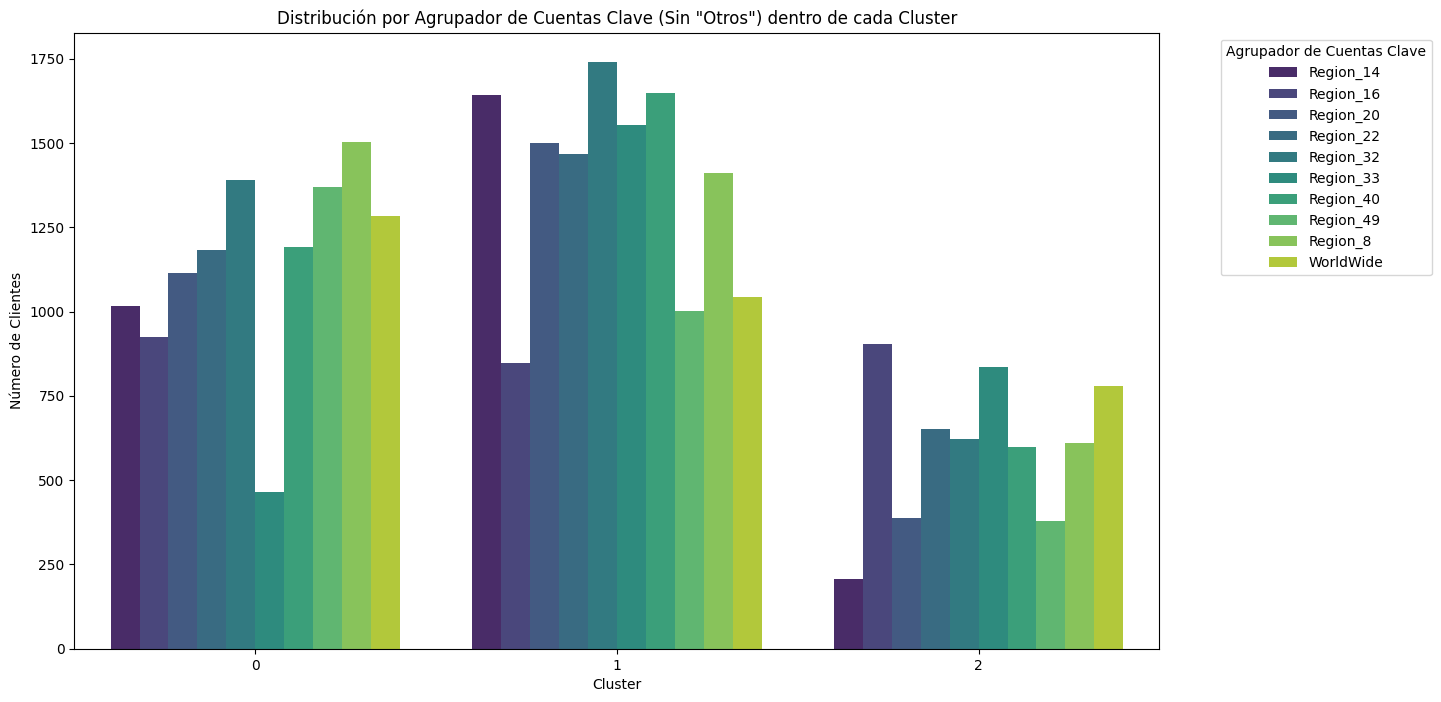

In [83]:
# Filtrar las categorías 'Otros'
df_key_account_grouper_cluster_filtered = df_key_account_grouper_cluster[df_key_account_grouper_cluster['Key_Account_Grouper_Simplified'] != 'Otros']

# Agrupar por cluster y la columna 'Key_Account_Grouper_Simplified' sin 'Otros'
key_account_grouper_cluster_counts_filtered = df_key_account_grouper_cluster_filtered.groupby(['Cluster', 'Key_Account_Grouper_Simplified']).size().reset_index(name='Count')

plt.figure(figsize=(14, 8))
sns.barplot(x='Cluster', y='Count', hue='Key_Account_Grouper_Simplified', data=key_account_grouper_cluster_counts_filtered, palette='viridis')
plt.title('Distribución por Agrupador de Cuentas Clave (Sin "Otros") dentro de cada Cluster')
plt.xlabel('Cluster')
plt.ylabel('Número de Clientes')
plt.legend(title='Agrupador de Cuentas Clave', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

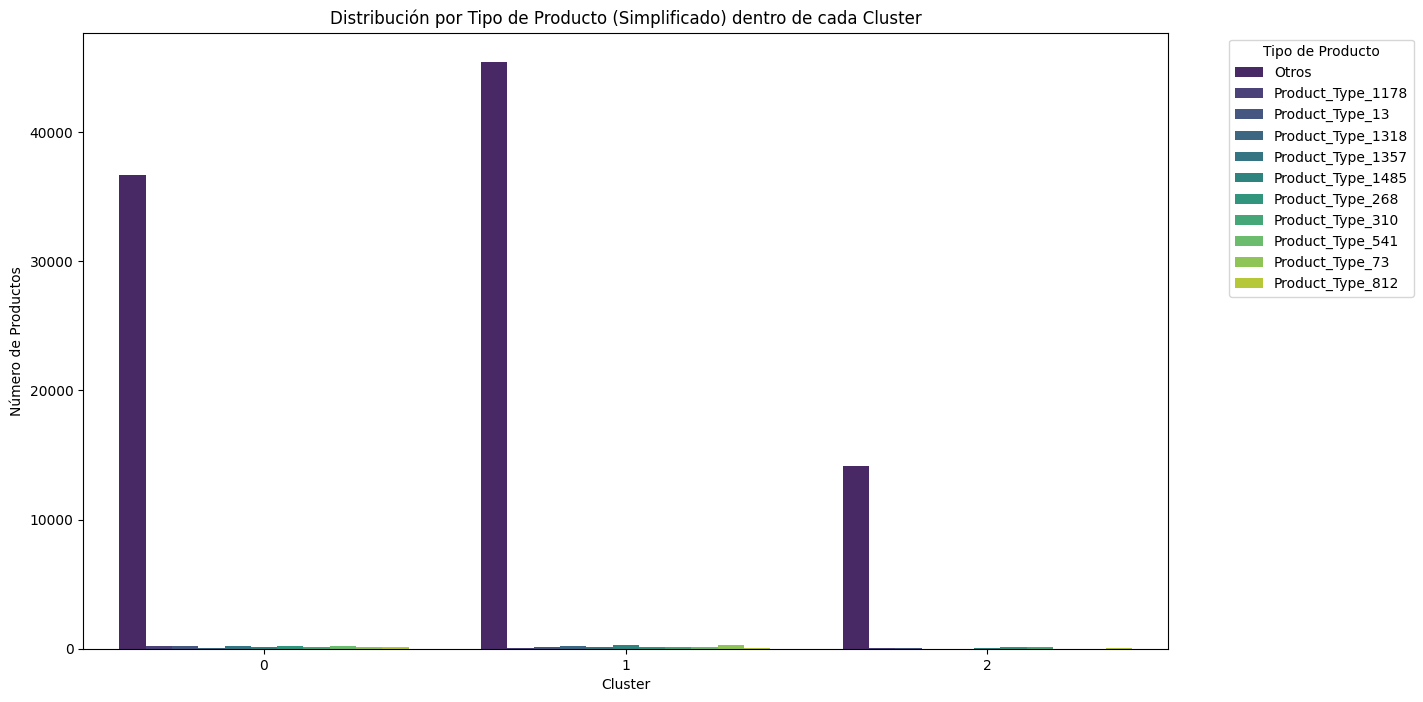

In [84]:
# Obtener las 10 categorías más frecuentes en 'Product_Type'
top_product_types = df_main_data['Product_Type'].value_counts().nlargest(10).index

# Crear una columna 'Product_Type_Simplified' donde las categorías menos frecuentes se agrupan en 'Otros'
df_main_data['Product_Type_Simplified'] = df_main_data['Product_Type'].apply(lambda x: x if x in top_product_types else 'Otros')

# Agrupar por cluster y la nueva columna 'Product_Type_Simplified'
df_product_type_cluster = df_main_data[['Client', 'Product_Type_Simplified', 'Cluster']]
product_type_cluster_counts = df_product_type_cluster.groupby(['Cluster', 'Product_Type_Simplified']).size().reset_index(name='Count')

plt.figure(figsize=(14, 8))
sns.barplot(x='Cluster', y='Count', hue='Product_Type_Simplified', data=product_type_cluster_counts, palette='viridis')
plt.title('Distribución por Tipo de Producto (Simplificado) dentro de cada Cluster')
plt.xlabel('Cluster')
plt.ylabel('Número de Productos')
plt.legend(title='Tipo de Producto', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

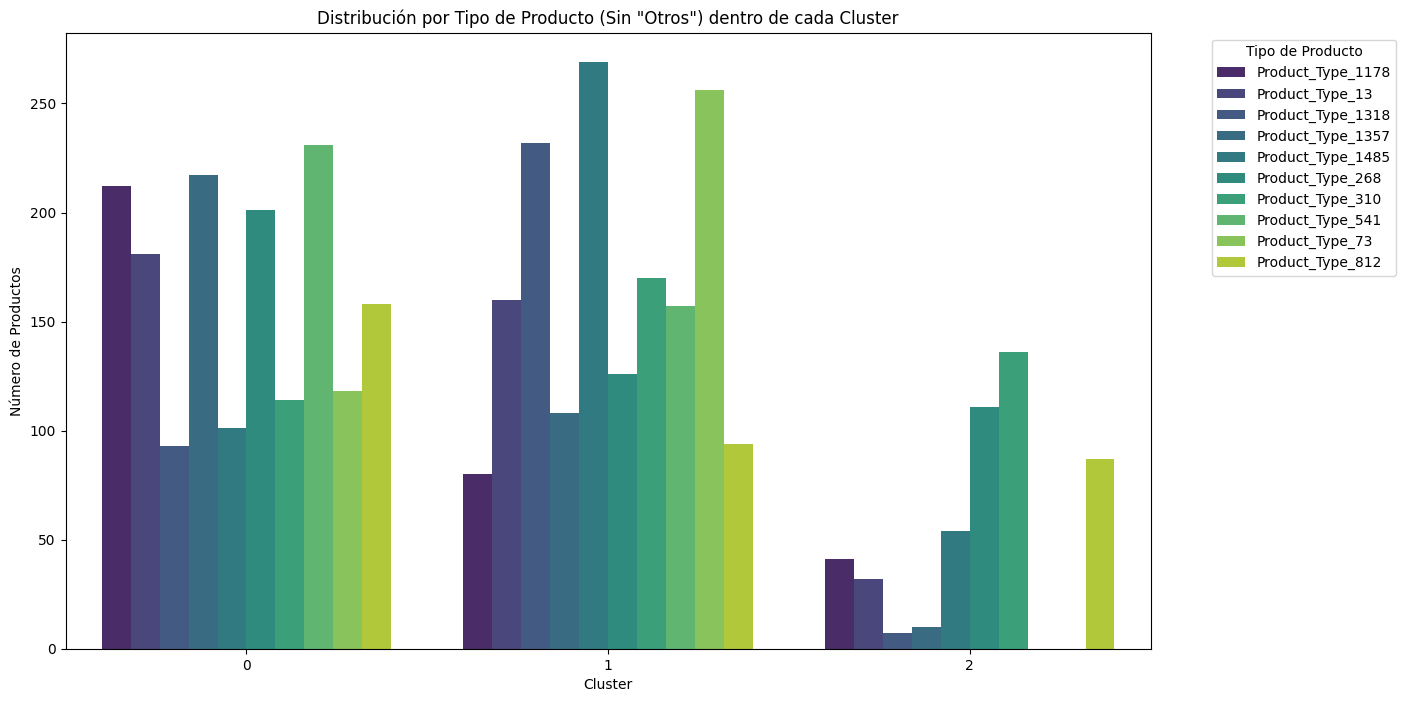

In [85]:
# Filtrar las categorías 'Otros'
df_product_type_cluster_filtered = df_product_type_cluster[df_product_type_cluster['Product_Type_Simplified'] != 'Otros']

# Agrupar por cluster y la columna 'Product_Type_Simplified' sin 'Otros'
product_type_cluster_counts_filtered = df_product_type_cluster_filtered.groupby(['Cluster', 'Product_Type_Simplified']).size().reset_index(name='Count')

plt.figure(figsize=(14, 8))
sns.barplot(x='Cluster', y='Count', hue='Product_Type_Simplified', data=product_type_cluster_counts_filtered, palette='viridis')
plt.title('Distribución por Tipo de Producto (Sin "Otros") dentro de cada Cluster')
plt.xlabel('Cluster')
plt.ylabel('Número de Productos')
plt.legend(title='Tipo de Producto', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

### Conclusión Final

1. **Explicación de la lógica del modelo:**
   - **Principios subyacentes y algoritmos:** El modelo utiliza el algoritmo de clustering K-means para segmentar a los clientes en grupos homogéneos. Se eligió este enfoque debido a su efectividad en la identificación de patrones en grandes conjuntos de datos y su capacidad para manejar variables continuas y categóricas.
   - **Cálculo de segmentaciones:** Las segmentaciones del modelo se basan en características clave como ventas netas. La importancia de estas segmentaciones radica en su capacidad para clasificar a los clientes según su valor y potencial para la empresa.
  

2. **Resultados del modelo:**
   - **Clasificación y precisión:** El modelo ha clasificado a los clientes en 3 clusters principales. La precisión y fiabilidad de estas clasificaciones se evaluaron utilizando el índice de silueta, con un valor promedio de 0.62, indicando una segmentación sólida.
  

3. **Información adicional:**
   - **Tendencias y patrones:** Durante el análisis, se descubrieron varios patrones significativos. Por ejemplo:
     - **Patrones de compra:** Los clientes con una mayor diversidad de productos tienden a tener mayores volúmenes de ventas y representan un segmento más valioso.
     - **Anomalías:** Se identificaron algunos clientes con volúmenes de ventas altos pero baja diversificación de productos, lo que sugiere oportunidades para estrategias de venta cruzada.
   - **Utilidad para el equipo de ventas:** Esta segmentación permite al equipo de ventas priorizar a los clientes de mayor valor y potencial, y adaptar sus estrategias de manera más efectiva. También facilita la identificación de oportunidades de venta cruzada y mejora la comprensión de las necesidades de los clientes.


En conclusión, el modelo proporciona una herramienta poderosa para el departamento comercial, permitiéndole generar estrategias basadas en datos precisos y actualizados. Si se adquieren nuevos datos, el modelo permitirá asignar rápidamente a los clientes a los clusters correspondientes, manteniendo la eficiencia y efectividad en la segmentación y análisis de clientes.

In [87]:
df_main_data.columns

Index(['ID', 'Ship to Customer', 'MATERIAL', 'Window', 'Other_Data', 'Month',
       'Sales_Qty_2024', 'Sales_Qty_2023', 'Sales_Qty_2022', 'Sales_Qty_2021',
       'Net_Sales_2024', 'Net_Sales_2023', 'Net_Sales_2022', 'Net_Sales_2021',
       'P2_2024', 'P2_2023', 'P2_2022', 'P2_2021', 'Country', 'Customer Type',
       'Key_Account', 'Key_Account_Grouper', 'BRAND', 'SUB_BRAND',
       'Material Type', 'Product_Type', 'Product_SubType', 'Sourcing_Plant',
       'Sourcing_Vendor', 'Client', 'Cluster', 'Key_Account_Simplified',
       'Key_Account_Grouper_Simplified', 'Product_Type_Simplified'],
      dtype='object')

In [91]:
df_cluster[['Segmentacion','Cluster']].set_index(('Cluster')).to_dict()

{'Segmentacion': {2: '151-200', 1: '101-150', 0: '51-100'}}

In [92]:
# Suponiendo que df_cluster tiene la columna 'Client' y 'Segmentacion'
# y que quieres mapear 'Segmentacion' al 'df_main_data' por 'Client'
client_segment_mapping = df_cluster[['Client', 'Segmentacion']]

# Añadir la segmentación al df_main_data por 'Client'
df_main_data = df_main_data.merge(client_segment_mapping, on='Client', how='left')

In [98]:
df_main_data.Segmentacion.value_counts()

Segmentacion
101-150    47070
51-100     38298
201-250     7012
151-200     7005
301-350      321
251-300      294
Name: count, dtype: int64

In [95]:
df_main_data.to_csv('data_obtained/df_main_datos.csv',index=False)

In [99]:
df_main_data.Net_Sales_2021.sum()

1717028459628.2922

In [126]:
df_main_data[(df_main_data['Segmentacion'] == '51-100') & (df_main_data['Cluster'] == 0)]['Net_Sales_2021'].sum()

656348486636.9011

In [128]:
df_main_data['P2_2021']

0        8271403.02
1       15885625.78
2              0.00
3        1234455.27
4              0.00
            ...    
99995   16166038.19
99996   23473871.03
99997          0.00
99998          0.00
99999          0.00
Name: P2_2021, Length: 100000, dtype: float64

In [127]:
datos['Main']['Net_Sales_2021']

0       48307537.39
1       18756854.10
2              0.00
3       15682967.08
4              0.00
            ...    
99995   20616876.72
99996   31751421.28
99997          0.00
99998          0.00
99999          0.00
Name: Net_Sales_2021, Length: 100000, dtype: float64

In [123]:
df_main_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 35 columns):
 #   Column                          Non-Null Count   Dtype   
---  ------                          --------------   -----   
 0   ID                              100000 non-null  int64   
 1   Ship to Customer                100000 non-null  object  
 2   MATERIAL                        100000 non-null  object  
 3   Window                          100000 non-null  object  
 4   Other_Data                      100000 non-null  object  
 5   Month                           100000 non-null  int64   
 6   Sales_Qty_2024                  100000 non-null  int64   
 7   Sales_Qty_2023                  100000 non-null  int64   
 8   Sales_Qty_2022                  100000 non-null  int64   
 9   Sales_Qty_2021                  100000 non-null  int64   
 10  Net_Sales_2024                  100000 non-null  float64 
 11  Net_Sales_2023                  100000 non-null  float64 
 12  Net